In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(136492)

#
# Custom plotting settings for seaborn
#
px, py = 600, 400 # width/height in pixels
sns_dpi = int(py/4.8) # w, h = (6.4, 4.8) is the default width/height
sns_fig_width  = px/sns_dpi
sns_fig_height = py/sns_dpi

sns.set(rc={
  'figure.figsize':(sns_fig_width, sns_fig_height),
  'figure.dpi': sns_dpi,
  'axes.labelweight': 'bold',
  'savefig.dpi': 4*sns_dpi,
})

sns_axes_color = '.25'
alt_axes_stype = sns.axes_style('whitegrid')
alt_axes_stype['xtick.color'] = sns_axes_color
alt_axes_stype['ytick.color'] = sns_axes_color
alt_axes_stype['axes.edgecolor'] = sns_axes_color
alt_axes_stype['xtick.bottom'] = True
alt_axes_stype['ytick.left'] = True
alt_axes_stype['axes.grid'] = False
alt_axes_stype['axes.spines.right'] = False
alt_axes_stype['axes.spines.top'] = False
sns.set_style(alt_axes_stype)

#
# Data generation helper functions
#

def generate_keys_zipf(nrows, a):
    ids = np.random.zipf(a, nrows)
    # ids = np.array(['%030x' % i for i in ids])
    return ids

def generate_correlated(r, Y):
    df = pd.DataFrame({
        'Y': Y, 
        'tmp': np.random.normal(0, 1, Y.shape[0])
    })
    lm = sm.ols(formula="tmp ~ Y", data=df).fit()
    generated = r * np.std(lm.resid) * Y + lm.resid * np.std(Y) * np.sqrt(1-r**2)
    return generated

def correlation(df, x, y):
    return np.corrcoef(df[x], df[y])[0,1]

def mi_ksg(X, Y, k=5):
    from sklearn.feature_selection import mutual_info_regression
    return mutual_info_regression(X.reshape(X.shape[0], 1), Y, discrete_features=False, n_neighbors=k, random_state=345)[0]


In [2]:
# Number of rows in the train table
nrows = 100
# Pearson's Correlation Coefficient
rho = 0.9

In [3]:
K_zipf = generate_keys_zipf(nrows, a=1.5)
Y_zipf = np.random.uniform(size=nrows)
df_zipf = pd.DataFrame({'K': K_zipf, 'Y': Y_zipf})
display(df_zipf.sample(3))

df_uniq = df_zipf.groupby(by='K').first().reset_index().copy()
K_uniq = df_uniq['K']
Y_uniq = df_uniq['Y']
display(df_uniq.sample(3))

X = generate_correlated(rho, Y_uniq)
df_aug = pd.DataFrame({'K': K_uniq, 'X': X})
display(df_aug.sample(3))

df_join_uniq = pd.merge(df_uniq, df_aug, on='K', how='left')
df_join_zipf = pd.merge(df_zipf, df_aug, on='K', how='left')
display(df_join_uniq.sample(5))
display(df_join_zipf.sample(5))

uniq_corr = correlation(df_join_uniq, 'Y', 'X')
zipf_corr = correlation(df_join_zipf, 'Y', 'X')
uniq_mi = mi_ksg(df_join_uniq['Y'].to_numpy(), df_join_uniq['X'].to_numpy())
zipf_mi = mi_ksg(df_join_zipf['Y'].to_numpy(), df_join_zipf['X'].to_numpy())
print(f'         MI uniq: {uniq_mi:.3f}  zipf: {zipf_mi:.3f}')
print(f'Correlation uniq: {uniq_corr:.3f}  zipf: {zipf_corr:.3f}')

,K,Y
17,4,0.537428
14,6,0.635703
15,230,0.760666


,K,Y
24,368,0.572652
16,28,0.725735
6,8,0.873502


,K,X
15,23,0.424905
25,381,0.947441
7,9,0.780534


,K,Y,X
21,66,0.598425,0.363332
2,3,0.228169,0.151670
5,6,0.635703,0.555045
0,1,0.627600,0.676916
27,919,0.412562,0.553541


,K,Y,X
99,1,0.087834,0.676916
85,1,0.056341,0.676916
83,28,0.725735,0.855642
7,52,0.346672,0.404711
22,16,0.092892,0.100800


         MI uniq: 0.782  zipf: 0.159
Correlation uniq: 0.900  zipf: 0.243


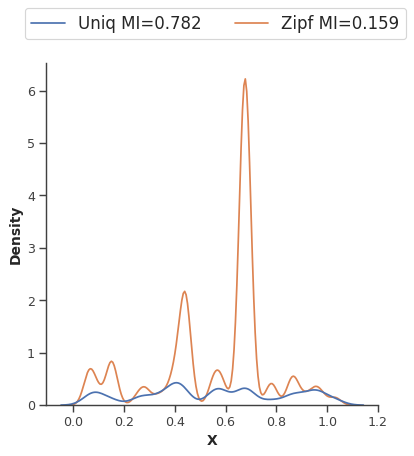

In [4]:
#
# Single plot with both tables
#
def merge_dfs(dfs=[], labels=[], markers=None):
    for i in range(len(dfs)):
        dfs[i] = dfs[i].copy()
        dfs[i]['Distribution'] = labels[i]
        if markers is not None:
            dfs[i]['marker'] = markers[i]
    return pd.concat(dfs).reset_index()

df_plot = merge_dfs(
    dfs=[df_join_uniq, df_join_zipf],
    labels=[f"Uniq MI={uniq_mi:.3f}", f"Zipf MI={zipf_mi:.3f}"],
    # labels=[f"Uniq r={uniq_corr:.3f}", f"Zipf corr={zipf_corr:.3f}"]
    markers=['+', 'x'],
)

ax = sns.displot(
    df_plot,
    x="X",
    hue="Distribution",
    kind="kde",
    bw_adjust=.25
    # binwidth=.025,
    # bins=10,
)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.4, 1.0), ncol=3, title=None, frameon=True,
    fontsize='large'
)

ax.savefig('./key-distribution_marginal.pdf')

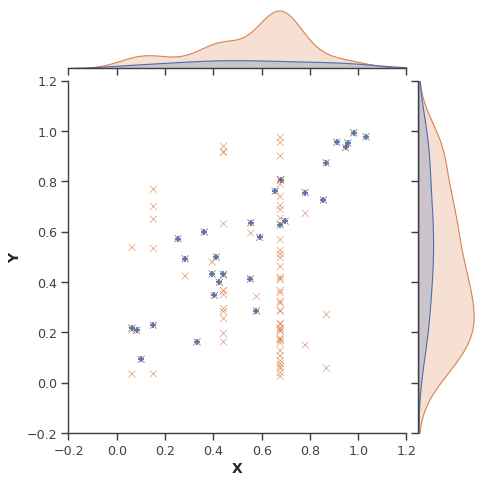

In [5]:
g = sns.jointplot(
    data=df_plot,
    x="X", y="Y",
    kind='scatter',
    xlim=(-0.2, 1.2),
    ylim=(-0.2, 1.2),
    marker='x',
    hue='Distribution',
    legend=False,
)

filter_uniq = df_plot['Distribution'].str.startswith('Uniq')

g.x = df_plot[filter_uniq].X
g.y = df_plot[filter_uniq].Y
plt.sca(g.ax_joint)
plt.scatter(x=g.x, y=g.y, marker='+')

g.savefig('./key-distribution_joint-dist.pdf')